Exercise 2: Train a VAE to generate images similar to the images of the given fashion-mnist dataset. 

The dataset is given in two csv files (train and test). ALL data should be used to train the VAE. The csv files have headers, their first columns contain labels, and the remaining columns contain image data.

Your should: write dataloaders, train an appropriate VAE, show a few samples and their corresponding decoded images, as well as a few of the generated samples.


In [ ]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-01-16 13:09:01--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-01-16 13:09:01--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1edaba2b8360b0fab56cc676ed.dl-eu.dropboxusercontent.com/cd/0/inline/B0ohJ3HWtuG2d4bPuUw1x0PXQ5emS2JXQGv1HmtkEJdcO5tIQIxQ3PIpNDMqmoacAScUuJpUVLgQlLoI60OQP7CkYAknoxShBBw3SGMY3injA1BbuykQCAr3TMQI149DSCwOgvm6Bjd1PSA9F_WvoX3bwz33h9sCLmIRf3DHLwy5lg/file# [following]
--2023-01-16 13:09:02--  https://uc1edaba2b8360b0fab56cc676ed.dl-eu.dropboxusercontent.com/cd/0/inline/B0ohJ3HWtuG2d4bPuUw1x0PXQ5emS2JXQGv1HmtkEJdcO5tIQIxQ3PIpN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary
import pandas as pd

In [ ]:
from torch.utils.data import Dataset
class DATA(Dataset):
    def __init__(self, imagesfile):
        super().__init__()
        df_x = imagesfile
        self.X = df_x.reshape(-1,1,28,28) 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        image = torch.tensor(image)/255.0
        return image

In [ ]:
datasetTest=pd.read_csv("/content/fashion-mnist_test.csv")
datasetTrain=pd.read_csv("/content/fashion-mnist_train.csv")

#print(datasetTrain)
#print(datasetTest.head())

# print(horizontal_concat)
batch_sz=64
# concat=pd.concat([datasetTest,datasetTrain],axis=1)
df_merged = datasetTest.append(datasetTrain, ignore_index=True)
df_merged=df_merged.iloc[:,1:]
df_merged=df_merged.iloc[1: , :]
df_merged=np.asarray(df_merged)

testset = DATA(df_merged)
trainloader = torch.utils.data.DataLoader(testset, batch_size=batch_sz,shuffle=True)
print(df_merged)
# print(concat.head())



[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 56  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [ ]:
class VarAutoEncoder(nn.Module):
  def __init__(self, nz=32):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 2, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32,64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear(64*4*4, 128)
    self.ebn4 = nn.BatchNorm1d(128)
    
    self.dlinear1 = nn.Linear(nz,128)
    self.dbn1 = nn.BatchNorm1d(128)
    self.dlinear2 = nn.Linear(128,64*4*4)
    self.dbn2 = nn.BatchNorm2d(64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding =1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding =1)
    
    self.ulinear = nn.Linear(128,nz)
    self.slinear = nn.Linear(128,nz)


  def encoder (self,x):
    x = F.leaky_relu(self.econv1(x))
    x = self.ebn1(x)
    x = F.leaky_relu(self.econv2(x))
    x = self.ebn2(x)
    x = F.leaky_relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,64*4*4)
    x = F.leaky_relu(self.elinear1(x))
    x = self.ebn4(x)
    return x
  
  def decoder(self, x):
    x = F.leaky_relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = F.leaky_relu(self.dlinear2(x))
    x = x.view(-1, 64,4,4)
    x = self.dbn2(x)
    x = F.leaky_relu(self.dconv1(x))
    x = self.dbn3(x)
    x = F.leaky_relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x

  def get_params(self,x):
    u = self.ulinear(x)
    logvar = self.slinear(x)
    return u, logvar

  def reparametarization(self, u, logvar):
    std = torch.exp(logvar/2)
    z = u + std*torch.randn_like(u)
    return z

  def forward(self,x):
    ex = self.encoder(x)
    u, logvar = self.get_params(ex)
    z = self.reparametarization(u, logvar)
    x = self.decoder(z)
    return ex,z, x, u, logvar 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = VarAutoEncoder(32).to(device)

summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
            Conv2d-3             [-1, 32, 7, 7]           4,640
       BatchNorm2d-4             [-1, 32, 7, 7]              64
            Conv2d-5             [-1, 64, 4, 4]          18,496
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Linear-7                  [-1, 128]         131,200
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 32]           4,128
           Linear-10                   [-1, 32]           4,128
           Linear-11                  [-1, 128]           4,224
      BatchNorm1d-12                  [-1, 128]             256
           Linear-13                 [-1, 1024]         132,096
      BatchNorm2d-14             [-1, 6

0 109.11465386301279
1 59.513588421046734
2 51.071037977933884
3 46.48645346984267
4 43.53354734182358
5 41.42158233746886
6 39.9696635119617
7 38.813676081597805
8 38.162860095500946
9 37.59710288606584


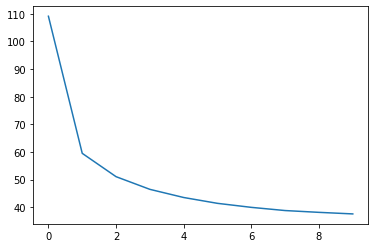

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = VarAutoEncoder(32).to(device)

num_epochs = 10
lr = 0.0001
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []

def var_loss(Xhat, X, u, logvar):
  KLD_WEIGHT = 0.0012
  term1 = F.mse_loss(Xhat, X)
  term2 = torch.mean(torch.sum(0.5*(1+logvar - torch.exp(logvar) - u**2), axis = 1), axis =0)
  return (1- KLD_WEIGHT)* term1 - KLD_WEIGHT*term2

for epoch in range(num_epochs):
  total_loss = 0
  for batch in trainloader:
    X = batch.to(device)
    ex, z,Xhat, u, logvar = net(X)
    loss = var_loss(Xhat, X,u, logvar )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(epoch, total_loss)

  ls.append(total_loss)

plt.plot(ls)

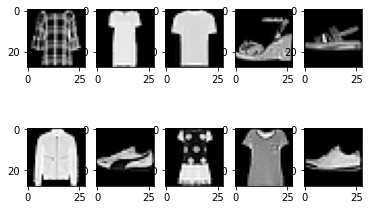

In [ ]:
#original
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X[i,0,:,:].detach().cpu().numpy(),cmap='gray')

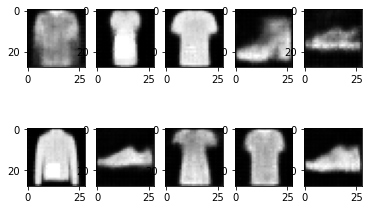

In [ ]:
#synthetic
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy(),cmap='gray')
 

In [ ]:
net.eval()
z = torch.randn(64,32)
Xhat = net.decoder(z)


torch.Size([64, 1, 28, 28]) torch.Size([28, 28]) torch.float32


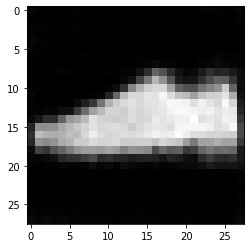

In [ ]:
img = Xhat[0, 0]
print(Xhat.shape, img.shape, img.dtype)
plt.imshow(img.detach().cpu().numpy(), cmap='gray')

torch.float32
torch.Size([3, 242, 242])


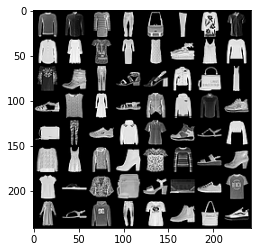

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    print(img.dtype)
    print(img.shape)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))